<a href="https://colab.research.google.com/github/DerickW126/Fake-News-Project/blob/main/FakeNews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!conda install -y pytorch torchvision cudatoolkit=10.1 -c pytorch
!pip install transformers

/bin/bash: conda: command not found
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import glob
from google.colab import drive
import numpy as np # linear algebra
import pandas as pd
import os
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
glob.glob("*.csv.zip")
drive.mount('/content/drive')
%cd /content/drive/MyDrive
os.system("unzip idk.zip")

Mounted at /content/drive
/content/drive/MyDrive


256

In [ ]:
from sklearn.utils import shuffle
true=pd.read_csv("True.csv")
false=pd.read_csv("Fake.csv")
true['is_fake'] = False
false['is_fake'] = True
df = pd.concat([true,false])
df = shuffle(df).reset_index(drop=True)
df.head()

,title,text,subject,date,is_fake
0,The Angry Left Attacks Trump for Letting 11-Ye...,President Trump just made an 11-year old boy s...,politics,"Sep 16, 2017",True
1,A DEFENSIVE JOHN KERRY Asks That Israel Move I...,John Kerry gave a long-winded speech today cla...,Government News,"Dec 28, 2016",True
2,Magellan Midstream probes big Texas fuel spill...,(Reuters) - Magellan Midstream Partners LP sai...,worldnews,"September 12, 2017",False
3,LOL! TRUMP TWEETS Hilarious Message To #Crooke...,President Trump on Saturday criticized Hillary...,politics,"Nov 18, 2017",True
4,Al Gore Tells Bill Maher: Get Rid Of Electora...,On the latest episode of Real Time with Bill M...,News,"August 6, 2017",True


In [ ]:
train_data, validate_data, test_data = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

train_data = train_data.reset_index(drop=True)
validate_data = validate_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

print("Size of training set: {}".format(len(train_data)))
print("Size of validation set: {}".format(len(validate_data)))
print("Size of testing set: {}".format(len(test_data)))

Size of training set: 26938
Size of validation set: 8980
Size of testing set: 8980


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
model.config.num_labels = 1

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
# Freeze the pre trained parameters
for param in model.parameters():
    param.requires_grad = False

# Add three new layers at the end of the network
model.classifier = nn.Sequential(
    nn.Linear(768, 256),
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Linear(64, 2),
    nn.Softmax(dim=1)
)

model = model.to(device)

In [ ]:
criterion = nn.MSELoss().to(device)
optimizer = optim.SGD(model.classifier.parameters(), lr=0.01)

In [ ]:
def preprocess_text(text):
    parts = []

    text_len = len(text.split(' '))
    delta = 300
    max_parts = 5
    nb_cuts = int(text_len / delta)
    nb_cuts = min(nb_cuts, max_parts)
    
    
    for i in range(nb_cuts + 1):
        text_part = ' '.join(text.split(' ')[i * delta: (i + 1) * delta])
        parts.append(tokenizer.encode(text_part, return_tensors="pt", max_length=500).to(device))

    return parts

In [ ]:
print_every = 300

total_loss = 0
all_losses = []

CUDA_LAUNCH_BLOCKING=1

model.train()

for idx, row in train_data.iterrows():
    text_parts = preprocess_text(str(row['text']))
    label = torch.tensor([row['is_fake']]).long().to(device)

    optimizer.zero_grad()

    overall_output = torch.zeros((1, 2)).float().to(device)
    for part in text_parts:
        if len(part) > 0:
            try:
                input = part.reshape(-1)[:512].reshape(1, -1)
                # print(input.shape)
                overall_output += model(input, labels=label)[1].float().to(device)
            except Exception as e:
                print(str(e))

#     overall_output /= len(text_parts)
    overall_output = F.softmax(overall_output[0], dim=-1)

    if label == 0:
        label = torch.tensor([1.0, 0.0]).float().to(device)
    elif label == 1:
        label = torch.tensor([0.0, 1.0]).float().to(device)

    # print(overall_output, label)

    loss = criterion(overall_output, label)
    total_loss += loss.item()
    
    loss.backward()
    optimizer.step()

    if idx % print_every == 0 and idx > 0:
        average_loss = total_loss / print_every
        print("{}/{}. Average loss: {}".format(idx, len(train_data), average_loss))
        all_losses.append(average_loss)
        total_loss = 0
        
    

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


300/26938. Average loss: 0.2413669581214587
600/26938. Average loss: 0.22359637928505738
900/26938. Average loss: 0.19966527508571744
1200/26938. Average loss: 0.17999882258552438
1500/26938. Average loss: 0.14504022442240966
1800/26938. Average loss: 0.13783512297571482
2100/26938. Average loss: 0.11567534746408152
2400/26938. Average loss: 0.11927769066662829
2700/26938. Average loss: 0.10745051171722783
3000/26938. Average loss: 0.10030559158740895
3300/26938. Average loss: 0.1059571985103806
3600/26938. Average loss: 0.11156155895742813
3900/26938. Average loss: 0.08543280050462121
4200/26938. Average loss: 0.10858471381719027
4500/26938. Average loss: 0.08289863490983407
4800/26938. Average loss: 0.08549683289209498
5100/26938. Average loss: 0.09848628818258173
5400/26938. Average loss: 0.08573774106299728
5700/26938. Average loss: 0.09859324737337981
6000/26938. Average loss: 0.07705287693052014
6300/26938. Average loss: 0.08286022209735772
6600/26938. Average loss: 0.07572466408

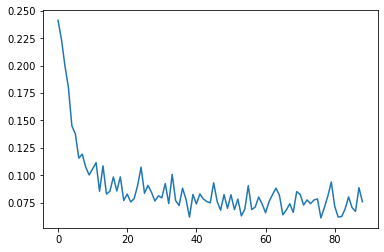

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline
torch.save(model.state_dict(), "model_after_train.pt")

plt.plot(all_losses)

In [ ]:
total = len(test_data)
number_right = 0
model.eval()
with torch.no_grad():
    for idx, row in test_data.iterrows():
        text_parts = preprocess_text(str(row['text']))
        label = torch.tensor([row['is_fake']]).float().to(device)
        
        overall_output = torch.zeros((1,2)).to(device)
        try:
            for part in text_parts:
                if len(part) > 0:
                    overall_output += model(part.reshape(1, -1))[0]
        except RuntimeError:
            print("GPU out of memory, skipping this entry.")
            continue
            
        overall_output = F.softmax(overall_output[0], dim=-1)
            
        result = overall_output.max(0)[1].float().item()
 
        if result == label.item():
            number_right += 1
            
        if idx % print_every == 0 and idx > 0:
            print("{}/{}. Current accuracy: {}".format(idx, total, number_right / idx))
            
print("Accuracy on test data: {}".format(number_right / total))

In [ ]:
def test(text):
    text_parts = preprocess_text(text)
    overall_output = torch.zeros((1,2)).to(device)
    try:
        for part in text_parts:
            if len(part) > 0:
                overall_output += model(part.reshape(1, -1))[0]
    except RuntimeError:
        print("GPU out of memory, skipping this entry.")

    overall_output = F.softmax(overall_output[0], dim=-1)

    value, result = overall_output.max(0)

    term = "fake"
    score = value.item()
    if result.item() == 0:
        term = "real"
    if (term == "fake") {
      score = 1 - score
    }
    if (score > 50): 
      print('real')
    else:
      print('fake')

SyntaxError: ignored

In [ ]:
fake1 = """
Americans to fund killing babies in abortion that she has been caught trying to add taxpayer financing of abortions to the bill to combat the Coronavirus and provide economic stimulus to the nation as it deals with the COVD-19 outbreak.
Nancy Pelosi has a long history of promoting abortion and her first act after becoming Speaker in 2019 was pushing legislation to use tax money for abortions. So it’s no surprise she is trying to exploit the Coronavirus pandemic to push abortion funding again.
As The Daily Caller reports: House Speaker Nancy Pelosi sought to include a potential way to guarantee federal funding for abortion into the coronavirus economic stimulus plan, according to multiple senior White House officials.
Speaking to the Daily Caller, those officials alleged that while negotiating the stimulus with U.S. Treasury Secretary Steve Mnuchin, Pelosi tried to lobby for “several” provisions that stalled bipartisan commitment to the effort. One was a mandate for up to $1 billion to reimburse laboratory claims, which White House officials say would set a precedent of health spending without protections outlined in the Hyde Amendment.
LifeNews depends on the support of readers like you to combat the pro-abortion media. Please donate now.
“A New mandatory funding stream that does not have Hyde protections would be unprecedented,” one White House official explained. “Under the guise of protecting people, Speaker Pelosi is working to make sure taxpayer dollars are spent covering abortion—which is not only backwards, but goes against historical norms.”
A second White House official referred to the provision as a “slush fund” and yet another questioned “what the Hyde Amendment and abortion have to do with protecting Americans from coronavirus?”
Americans should insist to their members of Congress that we need a clean bill that provides aggressive action to help patients and spur the economy. Killing babies with our tax dollars is not the answer to the coronavirus and the situation should not be exploited for political gain.
"""

true1 = """
Price spikes, however, would cause demand to wither and some expensive avocados might be leftover, and stores might try to ration avocados, he added.
"Exactly what the retail strategy would be in this case, I’m not sure. But we would have vastly fewer avocados," Sumner said.
Just how fast avocados would disappear, if at all, would depend on whether the Trump administration enacts a full or partial border closure. White House economic adviser Larry Kudlow told CNBC he’s looking for ways to keep some commerce flowing.
"We are looking at different options, particularly if you can keep those freight lanes, the truck lanes, open," he said this week.  
Ben Holtz owns Rocky H Ranch, a 70-acre family-run avocado farm in northern San Diego County. He agreed avocados would run out within weeks.
"Mexico is the big player today. California is not. You shut down the border and California can’t produce to meet the demand," Holtz said. "There will be people without their guacamole."
While Mexico’s avocado harvest is year-round, California’s is limited to April through July. Growers in the state have picked only about 3 percent of what’s expected to be a much smaller crop of about 175 million pounds this year, Holtz said. A heat wave last summer reduced the crop size.
California’s avocado harvest has averaged approximately 300 million pounds in recent years, according to data from the California Avocado Commission. By contrast, the U.S. has imported more than 1.5 billion pounds of avocados from Mexico annually. Representatives from the commission did not respond to requests for this article.
Altogether, the U.S. received 43 percent of its fruit and vegetable imports from Mexico in 2016, according to the U.S. Department of Agriculture.
Also affecting this year’s avocado supply, a California avocado company in March recalled shipments to six states last month after fears the fruit might be contaminated with a bacterium that can cause health risks.
Until the early 2000s, California was the nation’s leading supplier of avocados, Holtz said. Mexico gradually overtook the state and now dominates sales in the U.S.
"It’s a very big possibility," Holtz said of avocado shortages. "Three weeks would dry up the Mexican inventory. California alone consumes more avocados than are grown in our state. Cold storage supply chain is basically three weeks or less of inventory. Most of the time it’s seven days."
A spokeswoman for the California Restaurant Association said "we haven’t heard concerns from restaurants, it doesn’t mean they aren’t worried." A national grocers association said it will "continue to closely monitor any developments" at the border, but did not have information about the potential impact on avocados.
"""

test(fake1)
test(true1)

In [ ]:
def save_model(model, model_name):
  model_path='Colab Notebooks/'
  final_path=model_path+model_name+'_.pkl'
  print(final_path)
  torch.save(model,final_path)
  print("Model success")

save_model(model,'Bert_Model')


In [ ]:
model_path='Colab Notebooks/Bert_Model_.pkl'
model=torch.load(model_path)
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=model.to(device)